### COVID-19 Simulator

A university project by Till Zemann and Ben Kampmann.

If you are missing any dependencies, you can set `install_dependencies = True` and download them via pip:

In [1]:
# install all dependencies

install_dependencies = False

if install_dependencies:
    !pip install scikit-image # for skimage.measure (needed for max-pooling in the pathfinding)
    !pip install pymunk       # for basic particle simulation utility (written in C -> much faster than python)
    !pip install numpy        # for arrays and useful functions
    !pip install pygame       # for showing the simulation visually
    !pip install matplotlib   # for plotting
    !pip install typing       # for typehints

In [2]:
import os
import random
import time

import numpy as np
import pygame as pg
import pymunk
import skimage.measure as measure

import matplotlib.pyplot as plt
import seaborn as sns

from objects import Person, Wall, Train
from pathfinding import Node, Queue, Pathfinder
from simulator import CovidSim

pygame 2.1.0 (SDL 2.0.16, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
""" Configure the experiment """

config = {
    "run_name": "testrun",
    "save_plots": True,
    "n_people": 500,
    "infection_prob": 0.3,
    "avg_incubation_time": 500,
    "avg_infectious_time": 1000,
    "max_timestep": 3000,
    "start_seed": 1,
    "n_runs": 1,
    "speedup_factor": 1,
    "debug_mode": False,
    "FPS": 60,
}

##### Important note:

If the precomputed heatmap isn't available, you can set `use_precomputed_heatmaps=False` in the cell below. This will compute the heatmap and save it as a numpy file. Only do this once though and then set it to `True` in all preceeding runs as the computation takes some time (in our case a few minutes).

In [4]:
""" set up the simulator """

sim = CovidSim(
    config["n_people"],
    config["infection_prob"],       # probability that a non-infected person
    config["avg_incubation_time"],  # avg. number of timesteps to change from infected to infectious
    config["avg_infectious_time"],  # avg. number of timesteps to change from infectious to removed
    config["debug_mode"],           # shows gridpoints and walls
    config["FPS"])                  # frames per sec. (changing this parameter does not result in faster simulation)

pf = Pathfinder(sim, use_precomputed_heatmaps=True)

world_array shape: (800, 800)
using precomputed heatmaps with shape (30, 800, 800)


In [5]:
""" run the simulation """

start_time = time.time()

# run the simulation n_runs times and average the returned data over all runs
for run_index in range(config["n_runs"]):
    print(f"starting run... [{run_index+1}/%s]" % config["n_runs"])
    data = sim.run(
        seed=config["start_seed"]+run_index,     # set a random seed in order to get reproducable results
        speedup_factor=config["speedup_factor"], # how fast the simulation runs (10 would be 10x faster than normal)
        max_timestep=config["max_timestep"],     # the max. number of time steps for one simulation run (e.g. 1000)
        return_data=True)                        # whether the simulation should return the collected data
    
    # unpack the data
    susceptible_counts, infected_counts, infectious_counts, removed_counts = data

    if run_index == 0:
        
        # create lists with datapoints from multiple runs
        susceptible_counts_data = [[] for i in range(len(susceptible_counts))]
        infected_counts_data = [[] for i in range(len(infected_counts))]
        infectious_counts_data = [[] for i in range(len(infectious_counts))]
        removed_counts_data = [[] for i in range(len(removed_counts))]

    # append the data from the current run to the lists
    for i in range(len(susceptible_counts)):
        susceptible_counts_data[i].append(susceptible_counts[i])
        infected_counts_data[i].append(infected_counts[i])
        infectious_counts_data[i].append(infectious_counts[i])
        removed_counts_data[i].append(removed_counts[i])   

# log the execution time
end_time = time.time()
execution_time = end_time - start_time
        
# prepare the data (get lists of averages) for plotting 
timesteps = [t for t in range(0, len(susceptible_counts))]
susceptible_counts_avg = [sum(datapoints)/len(datapoints) for datapoints in susceptible_counts_data]
infected_counts_avg = [sum(datapoints)/len(datapoints) for datapoints in infected_counts_data]
infectious_counts_avg = [sum(datapoints)/len(datapoints) for datapoints in infectious_counts_data]
removed_counts_avg = [sum(datapoints)/len(datapoints) for datapoints in removed_counts_data]

starting run... [1/1]


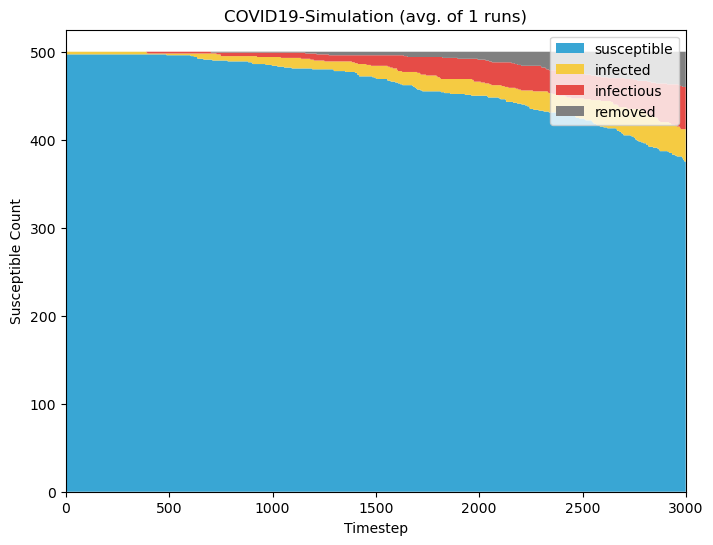

In [6]:
""" create the status stackplot """

run_name = config["run_name"]

if config["save_plots"]:
    # create the directories if they don't exist yet
    if not os.path.exists("plots"):
        os.mkdir("plots")
    if not os.path.exists(f"plots/{run_name}"):
        os.mkdir(f"plots/{run_name}")

        
# create the stackplot
fig1 = plt.figure(figsize=(8,6))
plt.stackplot(timesteps, susceptible_counts_avg, infected_counts_avg, infectious_counts_avg, removed_counts_avg,
              labels=["susceptible", "infected", "infectious", "removed"], 
              colors=["#39a6d4", "#f5cb42", "#e64c47", "gray"])

# if we used multiple runs, draw bars to show the variance between the runs
if config["n_runs"] > 1:
    n_variance_bars = 5  # how many variance bars should be plotted
    plt.boxplot([susceptible_counts_data[i*int(len(timesteps)/n_variance_bars)] for i in range(n_variance_bars)], 
    positions=[i*int(len(timesteps)/n_variance_bars) for i in range(n_variance_bars)], widths=int(len(timesteps)/50))

# configure the plot
plt.title(f"COVID19-Simulation (avg. of %i runs)" % config["n_runs"])
plt.legend(loc="upper right", ncol=1)
plt.xlabel("Timestep")
plt.ylabel("Susceptible Count")
plt.xlim(0, len(timesteps))

# save the figure
if config["save_plots"]:
    plt.savefig(f"plots/{run_name}/stackplot.pdf", format="pdf", dpi=400, bbox_inches="tight", pad_inches=0.1)

plt.show()

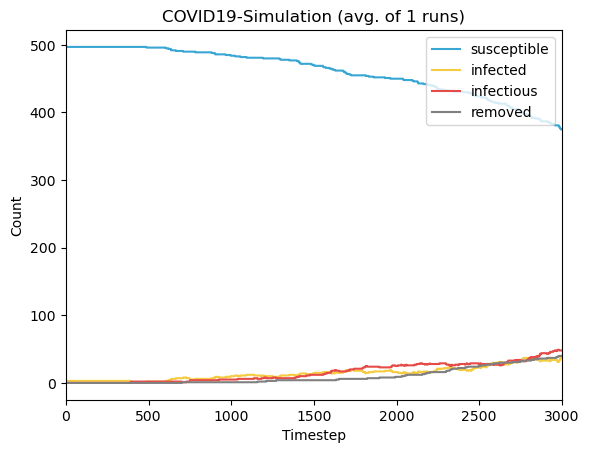

In [7]:
""" create the status graphs """

plt.plot(susceptible_counts_avg, label="susceptible", color="#39a6d4")
plt.plot(infected_counts_avg, label="infected", color="#f5cb42")
plt.plot(infectious_counts_avg, label="infectious", color="#e64c47")
plt.plot(removed_counts_avg, label="removed", color="gray")

plt.title(f"COVID19-Simulation (avg. of %i runs)" % config["n_runs"])
plt.legend(loc="upper right", ncol=1)
plt.xlabel("Timestep")
plt.ylabel("Count")
plt.xlim(0, len(timesteps))

# save the figure
if config["save_plots"]:
    plt.savefig(f"plots/{run_name}/graphs.pdf", format="pdf", dpi=400, bbox_inches="tight", pad_inches=0.1)

plt.show()

In [8]:
""" save the parameter configuration for the run """

if config["save_plots"]:

    # save the config dictionary to a "config.txt" file in the directory of the current run
    with open(f"plots/{run_name}/config.txt", "w") as config_file:
        config_file.write(f"# Configuration of the experiment '%s' \n" % config["run_name"])
        config_file.write(f"# Execution time: {execution_time:.1f} seconds\n\n")
        for key, value in config.items():
            config_file.write(f"{key}={value}\n")